 # Assignment 3
 ### Arpit Parihar
 ### 04/21/2021
 ****

 **Importing modules**

In [1]:
import warnings
import numpy as np
import pandas as pd
from pandas.core.indexes.multi import MultiIndex
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pretty_cm import pretty_plot_confusion_matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
%pylab inline
%config InlineBackend.figure_formats = ['png']

Populating the interactive namespace from numpy and matplotlib


 ### 1\. Data Processing:

 a) Import the data: shape should be (30000,24)

In [2]:
data = pd.read_excel('default of credit card clients.xls')
data.shape

(30000, 25)

 b) Remove any rows that have missing data.

In [3]:
data.dropna(inplace=True)
data.shape

(30000, 25)

 c) The target / y variable is "default payment next month" column. Keep all predictors for the X df except for the target variable.

In [4]:
X = data.drop(columns='default payment next month')
y = data['default payment next month']

 d) Split data into train / test set using an 70/30 split. Recall that you should be generating an X_train, X_test, y_train, and y_test.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=7)

 ### 2\. Random Forest Classifier - Base Model:

 a) Use the RandomForestClassifier in sklearn. Fit your model on the training data & make sure to add a random_state (check documentation to confirm how to do this).

In [6]:
rf_base = RandomForestClassifier(random_state=7)
rf_base.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

 b) Use the fitted model to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [7]:
y_pred_base = rf_base.predict(X_test)
y_prob_base = rf_base.predict_proba(X_test)[:, 1]

 c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

 d) Calculate the roc_auc_score for this model. There are many ways to do this, but an example is to use the probabilities from step B and utilize the roc_auc_score from sklearn.

In [8]:


class color:    # class to format print statements
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


# function to print classification results
def classification_results(act, pred, prob, header=None):
    labels = ['Not Default', 'Default']
    print(color.UNDERLINE + color.BOLD + header + ':\n' + color.END)
    print('Confusion Matrix:\n')
    plt.pause(1)
    pretty_plot_confusion_matrix(pd.DataFrame(confusion_matrix(
        act, pred), columns=labels, index=labels), pred_val_axis='x')
    plt.show()
    print('\n' + '-' * 75 + '\n')
    print(classification_report(act, pred, digits=4))
    print('\n' + '-' * 75 + '\n')
    print('AUROC: %2.2f%%' % (100 * roc_auc_score(act, prob)))
    print('\n' + '-' * 75 + '\n')
    precision, recall, thresholds = precision_recall_curve(act, prob)
    print('AUPRC: %2.2f%%' % (100 * auc(recall, precision)))
    print('\n')



Untuned Test Performance:

Confusion Matrix:



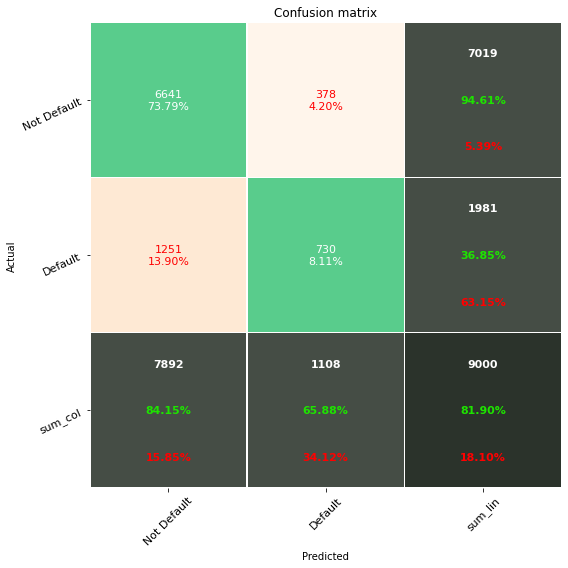


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8415    0.9461    0.8908      7019
           1     0.6588    0.3685    0.4726      1981

    accuracy                         0.8190      9000
   macro avg     0.7502    0.6573    0.6817      9000
weighted avg     0.8013    0.8190    0.7987      9000


---------------------------------------------------------------------------

AUROC: 76.70%

---------------------------------------------------------------------------

AUPRC: 53.98%




In [9]:
classification_results(y_test, y_pred_base, y_prob_base,
                       'Untuned Test Performance')

 e) Calculate predictions for the training data & build the classification report & roc_auc_score. Are there signs of overfitting? Why or why not?

Untuned Train Performance:

Confusion Matrix:



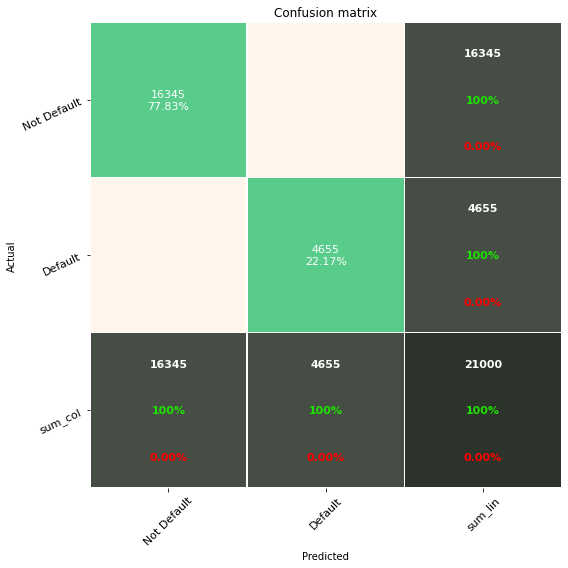


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     16345
           1     1.0000    1.0000    1.0000      4655

    accuracy                         1.0000     21000
   macro avg     1.0000    1.0000    1.0000     21000
weighted avg     1.0000    1.0000    1.0000     21000


---------------------------------------------------------------------------

AUROC: 100.00%

---------------------------------------------------------------------------

AUPRC: 100.00%




In [10]:
y_pred_base_tr = rf_base.predict(X_train)
y_prob_base_tr = rf_base.predict_proba(X_train)[:, 1]

classification_results(y_train, y_pred_base_tr,
                       y_prob_base_tr, 'Untuned Train Performance')

 The model fits perfectly to training dataset, and has an accuracy of 100%, while the performance on test data is much lower, especially for the minority class (1). The model is overfitting.

 ### 3\. Random Forest Classifier - Grid Search:

 a) Use the RandomForestClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following:

 - n_estimators: 50, 100, 500
 - max_features: 2, 4, sqrt
 - max_depth: 6, 8, 10, 12

 Use 5 cross-fold and for scoring use "roc_auc" (this is the score that will be referenced when identifying the best parameters).

In [11]:
# Create gridsearch object with various combinations of parameters
try:
    rf_tuned = joblib.load('rf_tuned.pkl')
except:
    # create Random Forest model
    rf = RandomForestClassifier(random_state=7)
    # create a dictionary of parameters
    param_grid = {
        'n_estimators': [50, 100, 500],
        'max_features': [2, 4, 'sqrt'],
        'max_depth': [6, 8, 10, 12],
        'class_weight': [None, 'balanced', 'balanced_subsample']}
    rf_tuned = GridSearchCV(
        rf, param_grid, cv=5,
        scoring='roc_auc', refit=True, n_jobs=-1, verbose=5)
    rf_tuned.fit(X_train, y_train)
    joblib.dump(rf_tuned, 'rf_tuned.pkl')

 b) Identify the best performing model:

In [12]:
rf_tuned.best_params_
rf_tuned.best_estimator_

{'class_weight': None, 'max_depth': 12, 'max_features': 2, 'n_estimators': 500}

RandomForestClassifier(max_depth=12, max_features=2, n_estimators=500,
                       random_state=7)

 c) Use the best estimator model to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [13]:
y_pred_tuned = rf_tuned.best_estimator_.predict(X_test)
y_prob_tuned = rf_tuned.best_estimator_.predict_proba(X_test)[:, 1]

 d) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

 e) Calculate the roc_auc_score for this model.

Tuned Test Performance:

Confusion Matrix:



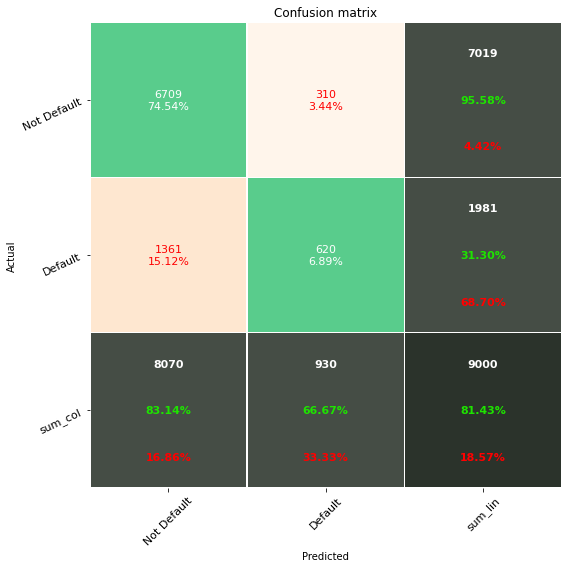


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8314    0.9558    0.8893      7019
           1     0.6667    0.3130    0.4260      1981

    accuracy                         0.8143      9000
   macro avg     0.7490    0.6344    0.6576      9000
weighted avg     0.7951    0.8143    0.7873      9000


---------------------------------------------------------------------------

AUROC: 78.09%

---------------------------------------------------------------------------

AUPRC: 54.97%




In [14]:
classification_results(y_test, y_pred_tuned,
                       y_prob_tuned, 'Tuned Test Performance')

 f) Calculate predictions for the training data & build the confusion matrix, classification report & roc_auc_score. Are there signs of overfitting? Why or why not?

Tuned Train Performance:

Confusion Matrix:



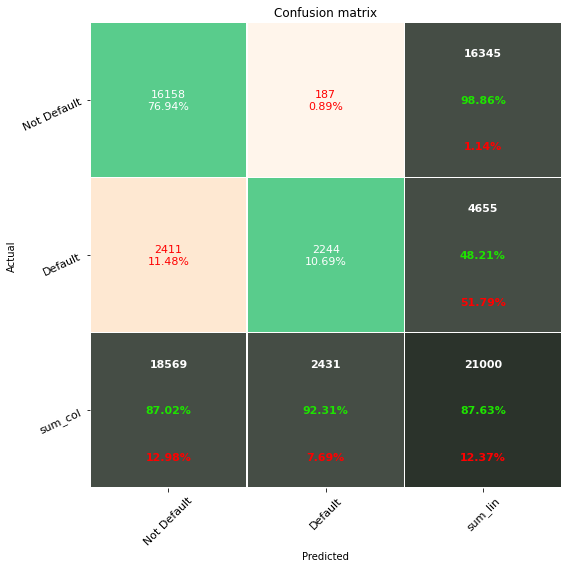


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8702    0.9886    0.9256     16345
           1     0.9231    0.4821    0.6334      4655

    accuracy                         0.8763     21000
   macro avg     0.8966    0.7353    0.7795     21000
weighted avg     0.8819    0.8763    0.8608     21000


---------------------------------------------------------------------------

AUROC: 91.03%

---------------------------------------------------------------------------

AUPRC: 80.02%




In [15]:
y_pred_tuned_tr = rf_tuned.best_estimator_.predict(X_train)
y_prob_tuned_tr = rf_tuned.best_estimator_.predict_proba(X_train)[:, 1]
classification_results(y_train, y_pred_tuned_tr,
                       y_prob_tuned_tr, 'Tuned Train Performance')

 The model is still overfitting, as the dip in performance from training to test performance is still significant, but it's better than the default model, which fit perfectly to the training data

 ### 4\. Create a feature importance plot for your best performing model.

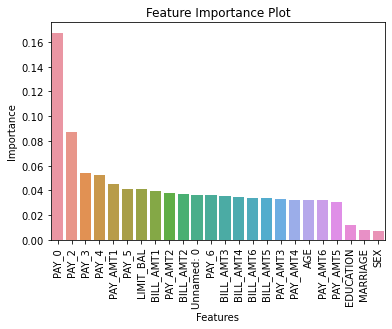

In [16]:
fi = sorted(list(rf_tuned.best_estimator_.feature_importances_), reverse=True)
cols = [x for _, x in sorted(
    zip(rf_tuned.best_estimator_.feature_importances_, X_train.columns), reverse=True)]
fi_plot = sns.barplot(cols, fi)
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.show(fi_plot);

 a) What are the top 5 features for this model?

In [17]:
print(color.UNDERLINE + color.BOLD + 'Top 5 Features:\n' + color.END)
cols[:5]

Top 5 Features:



['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_AMT1']

 ### 5\. Conceptual Questions:

 ** a) What are the best parameters from the Grid Search in Question # 3? Does the Model from #3 outperform Model #2? Explain why.**

 Best parameters from the grid search are:

 {'class_weight': None, 'max_depth': 12, 'max_features': 2, 'n_estimators': 500}

 Model #3 outperforms model #2. This is not clearly evident from the metrics (AUROC, AUPRC), but this could be the case only for this test dataset. Model #2 is highly overfit as compared to model #3, and the latter generalizes better, an will result in better performance on other unseen test datasets.

 ** b) Overfitting is always a concern in ML problems. Does Model #3 overfit data more or less than Model #2? Explain why you think this is the case.**

 No, model #2 overfits more than model #3, as the plunge in performance b/w training and test is much higher in model #2. This is because by default, the max depth pf decision trees is none, and the trees can grow deep enough to fit to the noise in data rather than the signal. Also, model #2 has 100 trees by default, while model #3 has 500, which reduces overfitting by adding more bias. Lastly, each tree in model #3 fits using a lot fewer features (2) compared to model #2 (sqrt(n_features)), which introduces more randomness and reduces overfitting.

 **c) The lecture notes describe the Gini Index which is the default criterion used for splitting in sklearn's version of RandomForestClassifier. How does the Gini Index work? (i.e. How is it used to build a top-performing model?).**

 Gini index is a measure of impurity, given by the expression:
 $$I_{G}(p) = \sum_{i=1}^{K}p_{i}(1-p_{i}) = 1 - \sum_{i=1}^{K}p_{i}^{2}$$
 Impurity means how well separated the leaf nodes are in terms of the target variable. Leaf nodes with an equal mix of 0s and 1s are bad, or "impure" nodes, as the confidence in prediction is low; the model is uncertain in predicting the class if both classes are equally likely. This results in a high gini value, while pure nodes result in low gini values.

 Decision trees split in a greedy fashion, which means they choose the feature and split point which results in the minimum gini value.

 **d) Describe how Random Forest is different from bagging & why this difference can yield improved results.**

 Random Forest also uses bootstrapping just like bagging, but introduces more randomness by considering only a few randomly chosen features instead of all for each split in each tree. This results in highly uncorrelated trees, which learn unique patterns in data and result in higher predictive power and lower overfitting.

 **e) Describe the importance of the max_depth parameter in Random Forest. Do not just provide a definition, rather think through how bias-variance tradeoff might be impacted by the max_depth parameter.**

 max_depth, as evident from the name controls how deep the trees are allowed to grow. This is set to None by default, which leads to the trees growing too deep, and learning the training data way to closely, including the noise in it. Deeper trees have higher variance, while shallower trees have high bias.

 **f) In this homework we used k-fold cross-validation while determining the optimal hyperparameters for our Random Forest model. 1) Describe how k-fold cross-validation works. 2) What benefit do we gain by using k-fold cross-validation when tuning our Random Forest model versus only using the train-test split approach?**

 k-fold CV divides the training data into k parts or "folds", trains the model on k-1 and tests on the last one, once per each fold. This leads to the model going through the entire training dataset instead of just a subset in train/validation split, and also prevents selection bias to some extent, as the splits are made multiple times and performance metrics are averaged instead of picking the best one.
